<a href="https://colab.research.google.com/github/YaokunLin/ActuaryProgrammer/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

bond_path='/content/drive/MyDrive/portfolio_optimization/AGG.csv'
bond_div_path='/content/drive/MyDrive/portfolio_optimization/AGG_div.csv'
stock_path='/content/drive/MyDrive/portfolio_optimization/VTI.csv'
stock_div_path='/content/drive/MyDrive/portfolio_optimization/VTI_div.csv'

'''
Data source from Yahoo Finance.
https://ca.finance.yahoo.com/quote/VTI/history?p=VTI
https://ca.finance.yahoo.com/quote/AGG/history?p=AGG
'''

df_bond_all_data = pd.read_csv(bond_path).sort_values(by='Date', ascending=False).set_index(['Date'])
df_bond_all_data['Adj_Return_Bon']=df_bond_all_data['Adj Close'].div(df_bond_all_data['Adj Close'].shift(-1))-1
#df_bond_all_data['Raw_Return_Bon']=df_bond_all_data['Close'].div(df_bond_all_data['Close'].shift(-1))-1
df_stock_all_data=pd.read_csv(stock_path).sort_values(by='Date', ascending=False).set_index(['Date'])
df_stock_all_data['Adj_Return_Sto']=df_stock_all_data['Adj Close'].div(df_stock_all_data['Adj Close'].shift(-1))-1
#df_stock_all_data['Raw_Return_Sto']=df_stock_all_data['Close'].div(df_stock_all_data['Close'].shift(-1))-1

df_bond_div= pd.read_csv(bond_div_path).sort_values(by='Date', ascending=False).set_index(['Date'])
df_stock_div= pd.read_csv(stock_div_path).sort_values(by='Date', ascending=False).set_index(['Date'])

Mounted at /content/drive


In [2]:
#user inputs
starter_amount=10**6
lookback_horizon = 5*252 #5yrs * 252 trade date / yr
invest_horizon=5*252
rebalance_trigger = 0.025 # when the weight is +/- a certain percentage (eg.+/- 2.5%), rebalance is triggered
risk_free_rate = 0.08/100 # 0.08%, 12M US T-BILL to carry foward the cash balance

In [3]:
df_bond=df_bond_all_data.head(lookback_horizon) # look back horizon to capture the data range
df_bond

,Open,High,Low,Close,Adj Close,Volume,Adj_Return_Bon
Date,,,,,,,
2021-06-01,114.360001,114.400002,114.160004,114.330002,114.330002,6209800,-0.000463
2021-05-28,114.550003,114.680000,114.500000,114.550003,114.383003,6768200,0.000000
2021-05-27,114.610001,114.620003,114.449997,114.550003,114.383003,5072300,-0.001221
2021-05-26,114.129997,114.800003,114.129997,114.690002,114.522797,3969400,-0.000349
2021-05-25,114.580002,114.750000,114.029999,114.730003,114.562744,6351700,0.002447
...,...,...,...,...,...,...,...
2016-06-06,111.169998,111.230003,111.070000,111.150002,98.265259,3278900,-0.001347
2016-06-03,111.150002,111.300003,111.120003,111.300003,98.397827,2210500,0.005420
2016-06-02,110.559998,110.739998,110.559998,110.699997,97.867386,2013900,0.002536


In [4]:
df_stock=df_stock_all_data.head(lookback_horizon)
df_stock

,Open,High,Low,Close,Adj Close,Volume,Adj_Return_Sto
Date,,,,,,,
2021-06-01,219.529999,219.529999,217.809998,218.179993,218.179993,3805700,0.000413
2021-05-28,218.600006,218.729996,218.029999,218.089996,218.089996,2635700,0.001699
2021-05-27,218.000000,218.240005,217.589996,217.720001,217.720001,2616200,0.001841
2021-05-26,216.979996,217.559998,216.479996,217.320007,217.320007,3258100,0.003602
2021-05-25,217.839996,218.020004,216.199997,216.539993,216.539993,3700600,-0.002763
...,...,...,...,...,...,...,...
2016-06-06,107.839996,108.459999,107.800003,108.250000,98.662262,1782300,0.005200
2016-06-03,107.779999,107.870003,106.940002,107.690002,98.151871,2502500,-0.002778
2016-06-02,107.400002,107.989998,107.110001,107.989998,98.425293,2112700,0.003345


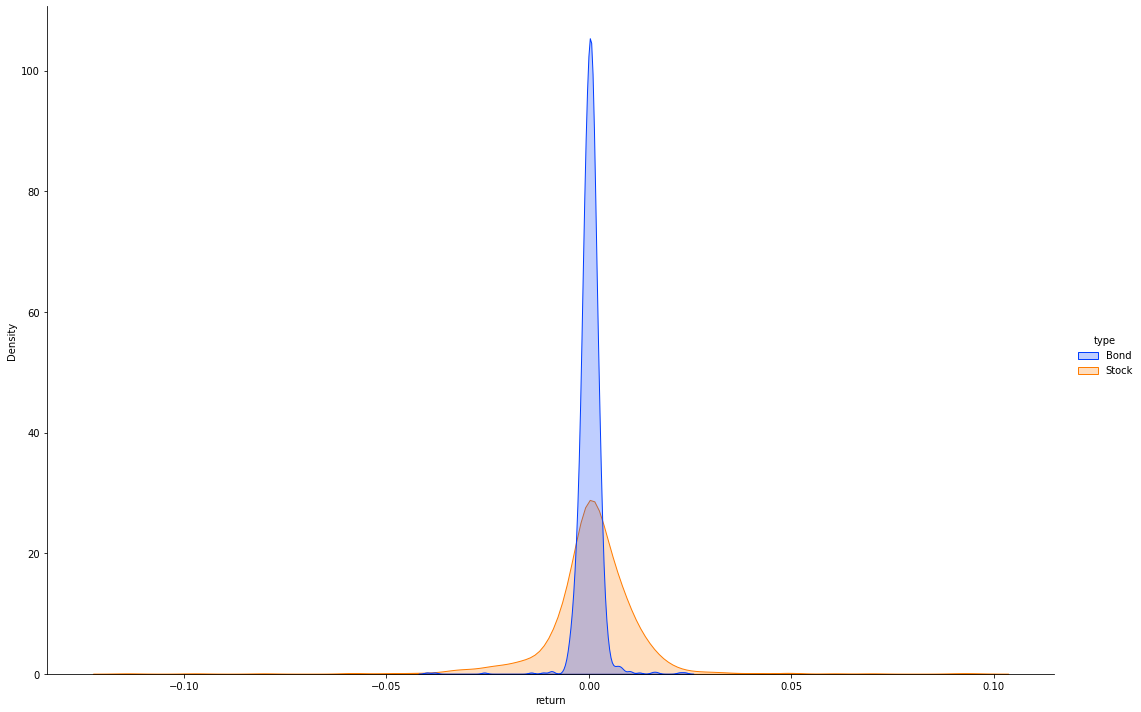

In [5]:
df_bond_temp = pd.DataFrame(df_bond.Adj_Return_Bon)
df_bond_temp['type'] = 'Bond'
df_bond_temp['return'] = df_bond_temp['Adj_Return_Bon']
df_stock_temp = pd.DataFrame(df_stock.Adj_Return_Sto)
df_stock_temp['type'] = 'Stock'
df_stock_temp['return'] = df_stock_temp['Adj_Return_Sto']


df_temp = pd.concat([df_bond_temp, df_stock_temp], axis=0)
df_temp = df_temp[['type','return']]

sns.displot(data=df_temp, x='return', hue='type', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=10, aspect=1.5)
del df_stock_temp,df_bond_temp,df_temp

In [6]:
df_return = pd.concat([df_bond.Adj_Return_Bon, df_stock.Adj_Return_Sto], axis=1)
df_return['Year'] = pd.DatetimeIndex(df_return.index).year
df_return

,Adj_Return_Bon,Adj_Return_Sto,Year
Date,,,
2021-06-01,-0.000463,0.000413,2021
2021-05-28,0.000000,0.001699,2021
2021-05-27,-0.001221,0.001841,2021
2021-05-26,-0.000349,0.003602,2021
2021-05-25,0.002447,-0.002763,2021
...,...,...,...
2016-06-06,-0.001347,0.005200,2016
2016-06-03,0.005420,-0.002778,2016
2016-06-02,0.002536,0.003345,2016


In [7]:
df_return.describe()[['Adj_Return_Bon', 'Adj_Return_Sto']]
# stock has a higher return + risk

,Adj_Return_Bon,Adj_Return_Sto
count,1260.000000,1260.000000
mean,0.000130,0.000710
std,0.002913,0.012062
min,-0.040011,-0.113808
25%,-0.001054,-0.002850
50%,0.000185,0.000849
75%,0.001317,0.005705
max,0.023721,0.094898


In [8]:
df_return.groupby(['Year']).describe().Adj_Return_Bon

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2016,150.0,-0.000052,0.002140,-0.009285,-0.001303,0.000179,0.001335,0.005420
2017,251.0,0.000141,0.001737,-0.004698,-0.001006,0.000182,0.001147,0.005786
2018,251.0,0.000015,0.001623,-0.004745,-0.001034,0.000094,0.000990,0.006596
2019,252.0,0.000324,0.002035,-0.005960,-0.000858,0.000361,0.001628,0.007835
2020,253.0,0.000299,0.005264,-0.040011,-0.000849,0.000529,0.001436,0.023721
2021,103.0,-0.000244,0.002272,-0.009180,-0.001276,-0.000340,0.000961,0.008129


In [9]:
df_return.groupby(['Year']).describe().Adj_Return_Sto

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2016,150.0,0.000604,0.007151,-0.036396,-0.002735,0.000590,0.004237,0.022100
2017,251.0,0.000776,0.004400,-0.017996,-0.001487,0.000528,0.002626,0.013465
2018,251.0,-0.000159,0.010545,-0.039349,-0.004092,0.000428,0.005704,0.048120
2019,252.0,0.001094,0.007945,-0.029683,-0.002221,0.001064,0.006178,0.033101
2020,253.0,0.000991,0.021594,-0.113808,-0.006010,0.002503,0.009661,0.094898
2021,103.0,0.001187,0.009543,-0.026131,-0.004002,0.001499,0.007630,0.025690


Text(0.5, 1.0, 'Bond Return vs. Stock Return')

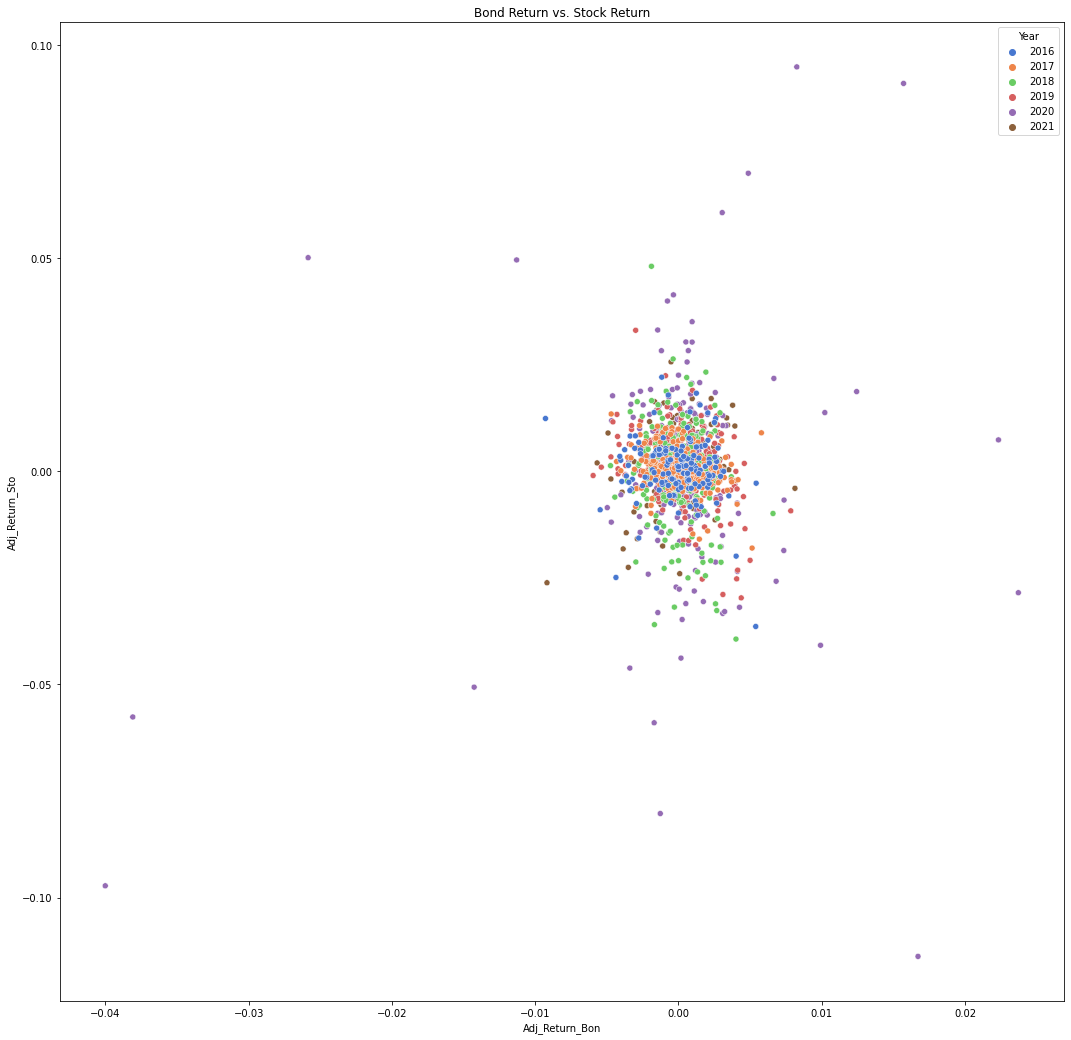

In [10]:
fig, ax = plt.subplots(figsize=(18,18))
sns.scatterplot(data=df_return, x="Adj_Return_Bon", y="Adj_Return_Sto", hue="Year", palette="muted").set_title('Bond Return vs. Stock Return')

In [11]:
class asset_class:
  horizon = lookback_horizon
  def __init__(my_asset, asset_type, annual_return, annual_std,VaR_90, VaR_95,VaR_99,VaR_995 ):
    my_asset.asset_type =asset_type 
    my_asset.annual_return = annual_return
    my_asset.annual_std = annual_std
    my_asset.VaR_90 = VaR_90
    my_asset.VaR_95 = VaR_95
    my_asset.VaR_99 = VaR_99
    my_asset.VaR_995 = VaR_995

In [12]:
bond= asset_class(
    asset_type='fixed income',               
    annual_return= df_return['Adj_Return_Bon'].mean()*252,
    annual_std=(252**0.5)*df_return['Adj_Return_Bon'].std(),
    VaR_90=df_return['Adj_Return_Bon'].mean()*252-(df_return['Adj_Return_Bon'].mean()-df_return['Adj_Return_Bon'].quantile(1-.9)*(252**0.5)),
    VaR_95=df_return['Adj_Return_Bon'].mean()*252-(df_return['Adj_Return_Bon'].mean()-df_return['Adj_Return_Bon'].quantile(1-.95)*(252**0.5)),
    VaR_99=df_return['Adj_Return_Bon'].mean()*252-(df_return['Adj_Return_Bon'].mean()-df_return['Adj_Return_Bon'].quantile(1-.99)*(252**0.5)),
    VaR_995=df_return['Adj_Return_Bon'].mean()*252-(df_return['Adj_Return_Bon'].mean()-df_return['Adj_Return_Bon'].quantile(1-.995)*(252**0.5)),)

print('asset class: ' + bond.asset_type)
print('look back horizon in days: ' + str(bond.horizon))
print('Avg annual return: ' + str(bond.annual_return))
print('Return std : ' + str(bond.annual_std))
print('VaR90 : ' + str(bond.VaR_90))
print('VaR95 : ' + str(bond.VaR_95))
print('VaR99 : ' + str(bond.VaR_99))
print('VaR995 : ' + str(bond.VaR_995))

asset class: fixed income
look back horizon in days: 1260
Avg annual return: 0.0326935309077022
Return std : 0.04624496977597211
VaR90 : -0.002922777513874375
VaR95 : -0.01767947479287474
VaR99 : -0.043894015584222644
VaR995 : -0.09808102937703217


In [13]:
stock= asset_class(
    asset_type='equity',               
    annual_return= df_return['Adj_Return_Sto'].mean()*252,
    annual_std=(252**0.5)*df_return['Adj_Return_Sto'].std(),
    VaR_90=df_return['Adj_Return_Sto'].mean()*252-(df_return['Adj_Return_Sto'].mean()-df_return['Adj_Return_Sto'].quantile(1-.9)*(252**0.5)),
    VaR_95=df_return['Adj_Return_Sto'].mean()*252-(df_return['Adj_Return_Sto'].mean()-df_return['Adj_Return_Sto'].quantile(1-.95)*(252**0.5)),
    VaR_99=df_return['Adj_Return_Sto'].mean()*252-(df_return['Adj_Return_Sto'].mean()-df_return['Adj_Return_Sto'].quantile(1-.99)*(252**0.5)),
    VaR_995=df_return['Adj_Return_Sto'].mean()*252-(df_return['Adj_Return_Sto'].mean()-df_return['Adj_Return_Sto'].quantile(1-.995)*(252**0.5)),)

print('asset class: ' + stock.asset_type)
print('look back horizon in days: ' + str(stock.horizon))
print('Avg annual return: ' + str(stock.annual_return))
print('Return std : ' + str(stock.annual_std))
print('VaR90 : ' + str(stock.VaR_90))
print('VaR95 : ' + str(stock.VaR_95))
print('VaR99 : ' + str(stock.VaR_99))
print('VaR995 : ' + str(stock.VaR_995))

asset class: equity
look back horizon in days: 1260
Avg annual return: 0.1788226674679456
Return std : 0.19147492104994193
VaR90 : 0.03104851876265391
VaR95 : -0.09653043601222991
VaR99 : -0.36026633078650283
VaR995 : -0.5436225542492487


In [14]:
cash= asset_class(
    asset_type='cash',               
    annual_return= risk_free_rate,
    annual_std=0,
    VaR_90=risk_free_rate,
    VaR_95=risk_free_rate,
    VaR_99=risk_free_rate,
    VaR_995=risk_free_rate,)

print('asset class: ' + cash.asset_type)
print('look back horizon in days: ' + str(cash.horizon))
print('Avg annual return: ' + str(cash.annual_return))
print('Return std : ' + str(cash.annual_std))
print('VaR90 : ' + str(cash.VaR_90))
print('VaR95 : ' + str(cash.VaR_95))
print('VaR99 : ' + str(cash.VaR_99))
print('VaR995 : ' + str(cash.VaR_995))

asset class: cash
look back horizon in days: 1260
Avg annual return: 0.0008
Return std : 0
VaR90 : 0.0008
VaR95 : 0.0008
VaR99 : 0.0008
VaR995 : 0.0008


In [15]:
class assets_correlation:
  horizon = lookback_horizon
  def __init__(my_corr, asset1, asset2):
    my_corr.asset1=asset1
    my_corr.asset2=asset2
  def set_correlation (my_corr, corr_value):
    my_corr.correlation = corr_value

bond_stock_corr = assets_correlation( asset1="bond", asset2="stock")
bond_stock_corr.set_correlation(df_return['Adj_Return_Sto'].corr(df_return['Adj_Return_Bon']))
print('look back horizon in days: ' + str(bond_stock_corr.horizon))
print("Correlation between stock and bond:" + str(bond_stock_corr.correlation))

look back horizon in days: 1260
Correlation between stock and bond:0.059208216621185895


In [16]:
class portfolio:
  my_bond=bond
  my_stock=stock
  my_bond_stock_corr=bond_stock_corr
  my_rfr=risk_free_rate
  horizon = lookback_horizon
  def __init__(my_port, bond_weight):
    my_port.bond_weight=bond_weight
    my_port.stock_weight=1-bond_weight
    my_port.expected_return = my_port.bond_weight * my_port.my_bond.annual_return+(my_port.stock_weight )*my_port.my_stock.annual_return
    my_port.std=( (my_port.bond_weight*my_port.my_bond.annual_std)**2 
                 + (my_port.stock_weight*my_port.my_stock.annual_std)**2
                 + (2*my_port.bond_weight*my_port.stock_weight*my_port.my_bond_stock_corr.correlation*my_port.my_bond.annual_std*my_port.my_stock.annual_std))**0.5
    my_port.Sharpe=(my_port.expected_return-my_port.my_rfr) / my_port.std

In [17]:
port1=portfolio(bond_weight=0.5)

print('sample portfolio:')
print("bond weight: "+str(port1.bond_weight))
print("stock weight: "+str(port1.stock_weight))
print("portfolio expected return: "+str(port1.expected_return))
print("portfolio std: "+str(port1.std))
print("portfolio Sharpe ratio: "+str(port1.Sharpe))

sample portfolio:
bond weight: 0.5
stock weight: 0.5
portfolio expected return: 0.10575809918782389
portfolio std: 0.09981206184908871
portfolio Sharpe ratio: 1.0515572691656823


In [18]:
bond_weight_list=[]
stock_weight_list=[]
port_return_list=[]
port_std_list=[]
port_sharpe_list=[]

for i in range(-500,1510,5):
  port=portfolio(bond_weight=i/1000)
  print("bond weight: "+str(port.bond_weight))
  bond_weight_list.append(port.bond_weight)
  print("stock weight: "+str(port.stock_weight))
  stock_weight_list.append(port.stock_weight)
  print("portfolio expected return: "+str(port.expected_return))
  port_return_list.append(port.expected_return)
  print("portfolio std: "+str(port.std))
  port_std_list.append(port.std)
  print("portfolio Sharpe ratio: "+str(port.Sharpe))
  port_sharpe_list.append(port.Sharpe)
  print("______________________________________________")
  del port


bond weight: -0.5
stock weight: 1.5
portfolio expected return: 0.25188723574806726
portfolio std: 0.2867737615806686
portfolio Sharpe ratio: 0.8755586088633048
______________________________________________
bond weight: -0.495
stock weight: 1.495
portfolio expected return: 0.2511565900652661
portfolio std: 0.28581460243117396
portfolio Sharpe ratio: 0.8759405150601204
______________________________________________
bond weight: -0.49
stock weight: 1.49
portfolio expected return: 0.25042594438246485
portfolio std: 0.28485552694195326
portfolio Sharpe ratio: 0.8763247357785431
______________________________________________
bond weight: -0.485
stock weight: 1.4849999999999999
portfolio expected return: 0.24969529869966364
portfolio std: 0.28389653596088427
portfolio Sharpe ratio: 0.8767112915176847
______________________________________________
bond weight: -0.48
stock weight: 1.48
portfolio expected return: 0.2489646530168624
portfolio std: 0.28293763034726466
portfolio Sharpe ratio: 0.87

In [19]:
stock_weight_series=pd.Series(stock_weight_list, index =bond_weight_list,name="stock_weight")
port_return_series=pd.Series(port_return_list, index =bond_weight_list,name="Expected_Port_Return")
port_std_series=pd.Series(port_std_list, index =bond_weight_list,name="Expected_Port_Std")
port_sharpe_series=pd.Series(port_sharpe_list, index =bond_weight_list,name="Port_Sharpe")

In [20]:
df_port=pd.concat([stock_weight_series,port_return_series,port_std_series,port_sharpe_series],axis=1)
df_port.index.name="bond_weight"

df_port

,stock_weight,Expected_Port_Return,Expected_Port_Std,Port_Sharpe
bond_weight,,,,
-0.500,1.500,0.251887,0.286774,0.875559
-0.495,1.495,0.251157,0.285815,0.875941
-0.490,1.490,0.250426,0.284856,0.876325
-0.485,1.485,0.249695,0.283897,0.876711
-0.480,1.480,0.248965,0.282938,0.877100
...,...,...,...,...
1.485,-0.485,-0.038179,0.112182,-0.347462
1.490,-0.490,-0.038910,0.113071,-0.351193
1.495,-0.495,-0.039640,0.113961,-0.354861


Text(0.5, 1.0, 'Sharpe Ratio Optimization')

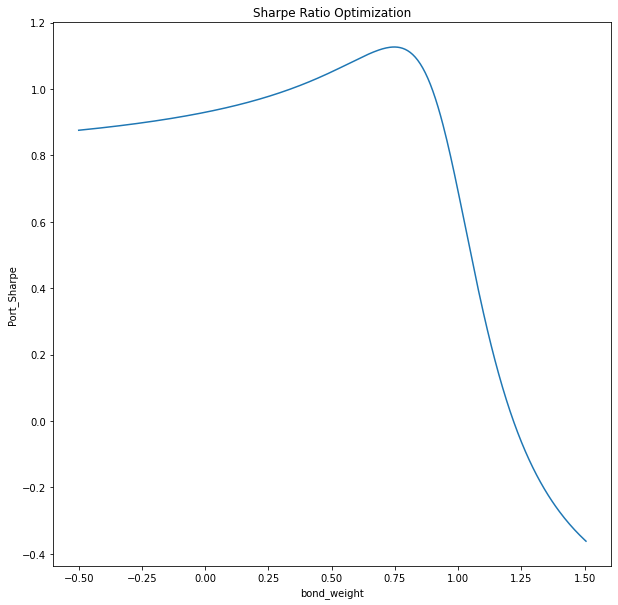

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_port, x="bond_weight", y="Port_Sharpe").set_title('Sharpe Ratio Optimization')

Text(0.5, 1.0, 'Efficient Frontier')

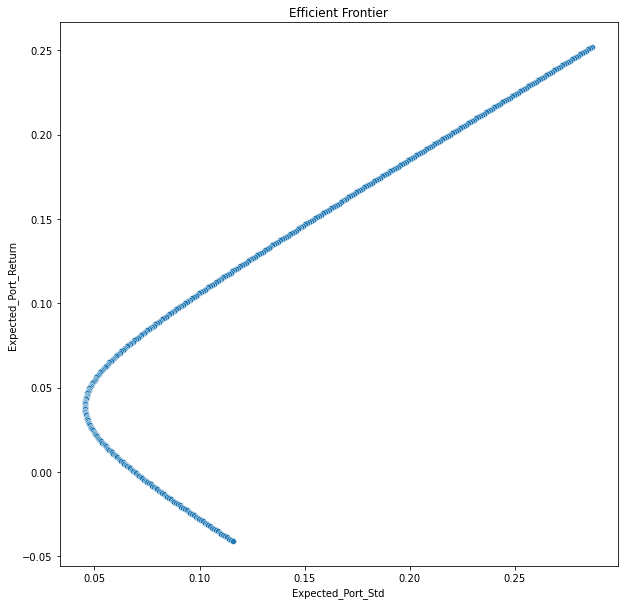

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df_port, x="Expected_Port_Std", y="Expected_Port_Return",  palette="muted").set_title('Efficient Frontier')

In [23]:
port_sharpe_optimized=portfolio(bond_weight_list[port_sharpe_list.index(max(port_sharpe_list))])
print("Sharpe Ratio Optimized Portfolio:")
print("bond weight: "+str(port_sharpe_optimized.bond_weight))
print("stock weight: "+str(port_sharpe_optimized.stock_weight))
print("expected return: "+str(port_sharpe_optimized.expected_return))
print("std: "+str(port_sharpe_optimized.std))
print("Sharpe ratio: "+str(port_sharpe_optimized.Sharpe))

Sharpe Ratio Optimized Portfolio:
bond weight: 0.745
stock weight: 0.255
expected return: 0.06995646073056426
std: 0.061401639856799375
Sharpe ratio: 1.1262966411296287


In [24]:
del bond_weight_list,stock_weight_list,port_return_list,port_std_list,port_sharpe_list,stock_weight_series,port_return_series,port_std_series,port_sharpe_series

In [25]:
#historical simulations
num_pt=min(len(df_bond_all_data),len(df_stock_all_data))-1
num_simulation=num_pt-invest_horizon+1

df_bond_sim= df_bond_all_data.head(num_pt)
df_stock_sim=df_stock_all_data.head(num_pt)

In [26]:
df_stock_sim

,Open,High,Low,Close,Adj Close,Volume,Adj_Return_Sto
Date,,,,,,,
2021-06-01,219.529999,219.529999,217.809998,218.179993,218.179993,3805700,0.000413
2021-05-28,218.600006,218.729996,218.029999,218.089996,218.089996,2635700,0.001699
2021-05-27,218.000000,218.240005,217.589996,217.720001,217.720001,2616200,0.001841
2021-05-26,216.979996,217.559998,216.479996,217.320007,217.320007,3258100,0.003602
2021-05-25,217.839996,218.020004,216.199997,216.539993,216.539993,3700600,-0.002763
...,...,...,...,...,...,...,...
2003-10-06,49.529999,49.744999,49.365002,49.674999,35.587185,194800,0.004348
2003-10-03,49.724998,49.825001,49.290001,49.459999,35.433132,258600,0.010935
2003-10-02,48.770000,48.965000,48.619999,48.924999,35.049866,125000,0.004517


In [27]:
df_bond_sim

,Open,High,Low,Close,Adj Close,Volume,Adj_Return_Bon
Date,,,,,,,
2021-06-01,114.360001,114.400002,114.160004,114.330002,114.330002,6209800,-0.000463
2021-05-28,114.550003,114.680000,114.500000,114.550003,114.383003,6768200,0.000000
2021-05-27,114.610001,114.620003,114.449997,114.550003,114.383003,5072300,-0.001221
2021-05-26,114.129997,114.800003,114.129997,114.690002,114.522797,3969400,-0.000349
2021-05-25,114.580002,114.750000,114.029999,114.730003,114.562744,6351700,0.002447
...,...,...,...,...,...,...,...
2003-10-06,101.639999,101.989998,101.599998,101.900002,57.679333,28700,0.001474
2003-10-03,102.050003,102.050003,101.699997,101.750000,57.594452,64500,-0.007219
2003-10-02,102.199997,102.650002,102.010002,102.489998,58.013260,68900,-0.001559


In [28]:
class portfolio_value:
  def __init__(my_port_value, bond_unit,bond_unit_price, stock_unit, stock_unit_price, cash ):
    my_port_value.time = 0
    my_port_value.bond_unit = bond_unit
    my_port_value.stock_unit = stock_unit

    my_port_value.bond_unit_price=bond_unit_price
    my_port_value.stock_unit_price=stock_unit_price
    
    my_port_value.cash=0
    my_port_value.bond_value= my_port_value.bond_unit * my_port_value.bond_unit_price
    my_port_value.stock_value= my_port_value.stock_unit * my_port_value.stock_unit_price

    my_port_value.value = my_port_value.cash + my_port_value.bond_value + my_port_value.stock_value

    my_port_value.bond_weight=my_port_value.bond_value / my_port_value.value
    my_port_value.stock_weight=my_port_value.stock_value / my_port_value.value

  def update_unit_price(my_port_value, bond_unit_price,stock_unit_price,bond_div_per_unit,stock_div_per_unit):
    my_port_value.time=my_port_value.time+1

    my_port_value.bond_unit_price=bond_unit_price
    my_port_value.stock_unit_price=stock_unit_price

    my_port_value.cash=my_port_value.cash*(1+risk_free_rate/365) + bond_div_per_unit*my_port_value.bond_unit+stock_div_per_unit*my_port_value.stock_unit
    my_port_value.bond_value= my_port_value.bond_unit * my_port_value.bond_unit_price
    my_port_value.stock_value= my_port_value.stock_unit * my_port_value.stock_unit_price

    my_port_value.value = my_port_value.cash + my_port_value.bond_value + my_port_value.stock_value

    my_port_value.bond_weight=my_port_value.bond_value / my_port_value.value
    my_port_value.stock_weight=my_port_value.stock_value / my_port_value.value

  def rebalance(my_port_value, bond_unit,stock_unit):
    my_port_value.bond_unit = bond_unit
    my_port_value.stock_unit = stock_unit

    my_port_value.bond_value= my_port_value.bond_unit * my_port_value.bond_unit_price
    my_port_value.stock_value= my_port_value.stock_unit * my_port_value.stock_unit_price

    my_port_value.cash = my_port_value.value - my_port_value.bond_value - my_port_value.stock_value

    my_port_value.bond_weight=my_port_value.bond_value / my_port_value.value
    my_port_value.stock_weight=my_port_value.stock_value / my_port_value.value
    

class asset_price:
  def __init__(my_asset_price, asset, initial_price ):
    my_asset_price.asset=asset
    my_asset_price.time=0
    my_asset_price.price=initial_price
  def update_price(my_asset_price,adj_asset_return,dividend):
    my_asset_price.time=my_asset_price.time+1
    my_asset_price.price=my_asset_price.price*(1+adj_asset_return) - dividend

In [29]:
def initilize_portfolio():

  #bond starting point
  bond_etf_price = asset_price(
      asset='bond',
      initial_price=df_bond_all_data["Close"].get('2021-06-01')
  )

  #stock starting point 
  stock_etf_price = asset_price(
      asset='equity',
      initial_price=df_stock_all_data["Close"].get('2021-06-01')
  )

  #starting position:
  simulated_portfolio=portfolio_value(
      bond_unit = starter_amount * port_sharpe_optimized.bond_weight / bond_etf_price.price,
      bond_unit_price = bond_etf_price.price, 
      stock_unit = starter_amount * port_sharpe_optimized.stock_weight / stock_etf_price.price, 
      stock_unit_price = stock_etf_price.price, 
      cash = 0)
  
  return bond_etf_price,stock_etf_price,simulated_portfolio

In [30]:
bond_etf_price,stock_etf_price,simulated_portfolio=initilize_portfolio()
print("Historical simulation, starting point: 2021-06-01")
print("Initial bond ETF unit price: " + str(simulated_portfolio.bond_unit_price))
print("Initial stock ETF unit price: " + str(simulated_portfolio.stock_unit_price))
print(" ")
print("Investment horizon in days: "+ str(invest_horizon))
print("Num. of simulations: "+str(num_simulation))
print(" ")
print("Optimized bond weight:" + str(simulated_portfolio.bond_weight))
print("Optimized stock weight: " + str(simulated_portfolio.stock_weight))
print("Rebalance threshold (+/-): " + str(rebalance_trigger))
print(" ")
print("Optimized Bond ETF units at start: " + str(simulated_portfolio.bond_unit))
print("Optimized Equity ETF units at start: " + str(simulated_portfolio.stock_unit))
print(" ")
print("Initial bond value: " + str(simulated_portfolio.bond_value))
print("Initial stock value: " + str(simulated_portfolio.stock_value))
print("Initial cash: " + str(simulated_portfolio.cash))
print(" ")
print("Initial portfolio value: " + str(simulated_portfolio.value))

Historical simulation, starting point: 2021-06-01
Initial bond ETF unit price: 114.33000200000001
Initial stock ETF unit price: 218.17999300000002
 
Investment horizon in days: 1260
Num. of simulations: 3189
 
Optimized bond weight:0.745
Optimized stock weight: 0.255
Rebalance threshold (+/-): 0.025
 
Optimized Bond ETF units at start: 6516.224848837141
Optimized Equity ETF units at start: 1168.7597771625192
 
Initial bond value: 745000.0
Initial stock value: 255000.00000000003
Initial cash: 0
 
Initial portfolio value: 1000000.0


In [31]:
simulation_list=[]
Simulated_portfolio_end_value=[]
for sim in range(num_simulation):
  print(str((sim+1)/num_simulation*100)+"% completed.")

  simulated_portfolio_path_list=[]
  bond_etf_price,stock_etf_price,simulated_portfolio=initilize_portfolio()

  for i in range(invest_horizon):
    sim_index=-i-1-sim

    if df_bond_div['Dividends'].get(df_bond_sim.index[sim_index]) == None:
      bond_div = 0
    else:
      bond_div_yield = df_bond_div['Dividends'].get(df_bond_sim.index[sim_index]) / df_bond_sim['Close'].get(df_bond_sim.index[sim_index])
      bond_div = bond_div_yield * bond_etf_price.price
      #print(bond_div_yield)

    if df_stock_div['Dividends'].get(df_stock_sim.index[sim_index]) == None:
      stock_div = 0
    else:
      stock_div_yield = df_stock_div['Dividends'].get(df_stock_sim.index[sim_index]) / df_stock_sim['Close'].get(df_stock_sim.index[sim_index])
      stock_div = stock_div_yield * stock_etf_price.price
      '''
      print(stock_div_yield)
      print( df_stock_div['Dividends'].get(df_stock_sim.index[sim_index]))
      print(stock_div)
      print(df_stock_sim['Close'].get(df_stock_sim.index[sim_index]))
      print(stock_etf_price.price)
      print("")
      '''
    bond_etf_price.update_price(
        adj_asset_return=df_bond_sim["Adj_Return_Bon"].get(df_bond_sim.index[sim_index]),
        dividend=bond_div)

    stock_etf_price.update_price(
        adj_asset_return=df_stock_sim["Adj_Return_Sto"].get(df_stock_sim.index[sim_index]),
        dividend=stock_div)
    
    simulated_portfolio.update_unit_price( 
        bond_unit_price=bond_etf_price.price,
        stock_unit_price=stock_etf_price.price,
        bond_div_per_unit=bond_div,
        stock_div_per_unit=stock_div)
    # rebalance
    if simulated_portfolio.bond_weight > (port_sharpe_optimized.bond_weight+rebalance_trigger) or (simulated_portfolio.bond_weight < port_sharpe_optimized.bond_weight-rebalance_trigger) or simulated_portfolio.stock_weight > (port_sharpe_optimized.stock_weight+rebalance_trigger) or simulated_portfolio.stock_weight < (port_sharpe_optimized.stock_weight-rebalance_trigger):
      simulated_portfolio.rebalance(
          bond_unit=simulated_portfolio.value*port_sharpe_optimized.bond_weight/bond_etf_price.price,
          stock_unit=simulated_portfolio.value*port_sharpe_optimized.stock_weight/stock_etf_price.price)
    
    simulated_portfolio_path_list.append(simulated_portfolio.value)

  simulation_list.append(simulated_portfolio_path_list)
  Simulated_portfolio_end_value.append(simulated_portfolio_path_list[-1])

0.03135779241141424% completed.
0.06271558482282848% completed.
0.09407337723424271% completed.
0.12543116964565695% completed.
0.15678896205707119% completed.
0.18814675446848542% completed.
0.21950454687989968% completed.
0.2508623392913139% completed.
0.28222013170272814% completed.
0.31357792411414237% completed.
0.3449357165255566% completed.
0.37629350893697083% completed.
0.40765130134838506% completed.
0.43900909375979935% completed.
0.4703668861712135% completed.
0.5017246785826278% completed.
0.533082470994042% completed.
0.5644402634054563% completed.
0.5957980558168705% completed.
0.6271558482282847% completed.
0.658513640639699% completed.
0.6898714330511132% completed.
0.7212292254625274% completed.
0.7525870178739417% completed.
0.783944810285356% completed.
0.8153026026967701% completed.
0.8466603951081844% completed.
0.8780181875195987% completed.
0.9093759799310128% completed.
0.940733772342427% completed.
0.9720915647538414% completed.
1.0034493571652556% completed.


In [32]:
simulated_port_end_value_df=pd.DataFrame(pd.Series(Simulated_portfolio_end_value,name="simulated_portfolio_value"))
simulated_port_end_value_df.describe()

,simulated_portfolio_value
count,3.189000e+03
mean,1.317973e+06
std,8.316419e+04
min,1.048442e+06
25%,1.275222e+06
50%,1.306659e+06
75%,1.353679e+06
max,1.636713e+06


In [36]:
avg_return = (simulated_port_end_value_df['simulated_portfolio_value'].mean()/starter_amount)**(1/(invest_horizon/252))-1
min_return = (simulated_port_end_value_df['simulated_portfolio_value'].min()/starter_amount)**(1/(invest_horizon/252))-1
VaR90=(simulated_port_end_value_df['simulated_portfolio_value'].quantile(1-0.9)/starter_amount)**(1/(invest_horizon/252))-1
VaR95=(simulated_port_end_value_df['simulated_portfolio_value'].quantile(1-0.95)/starter_amount)**(1/(invest_horizon/252))-1
VaR99=(simulated_port_end_value_df['simulated_portfolio_value'].quantile(1-0.99)/starter_amount)**(1/(invest_horizon/252))-1
VaR995=(simulated_port_end_value_df['simulated_portfolio_value'].quantile(1-0.995)/starter_amount)**(1/(invest_horizon/252))-1
print("backtest annual return: " + str(avg_return))

print("backtest VaR90 return: " + str(VaR90))
print("backtest VaR95 return: " + str(VaR95))
print("backtest VaR99 return: " + str(VaR99))
print("backtest VaR995 return: " + str(VaR995))
print("backtest min. return: " + str(min_return))

backtest annual return: 0.05677205587489276
backtest VaR90 return: 0.043352113583619456
backtest VaR95 return: 0.03617638388336264
backtest VaR99 return: 0.021993454303276927
backtest VaR995 return: 0.01847294926161447
backtest min. return: 0.009505956331956833


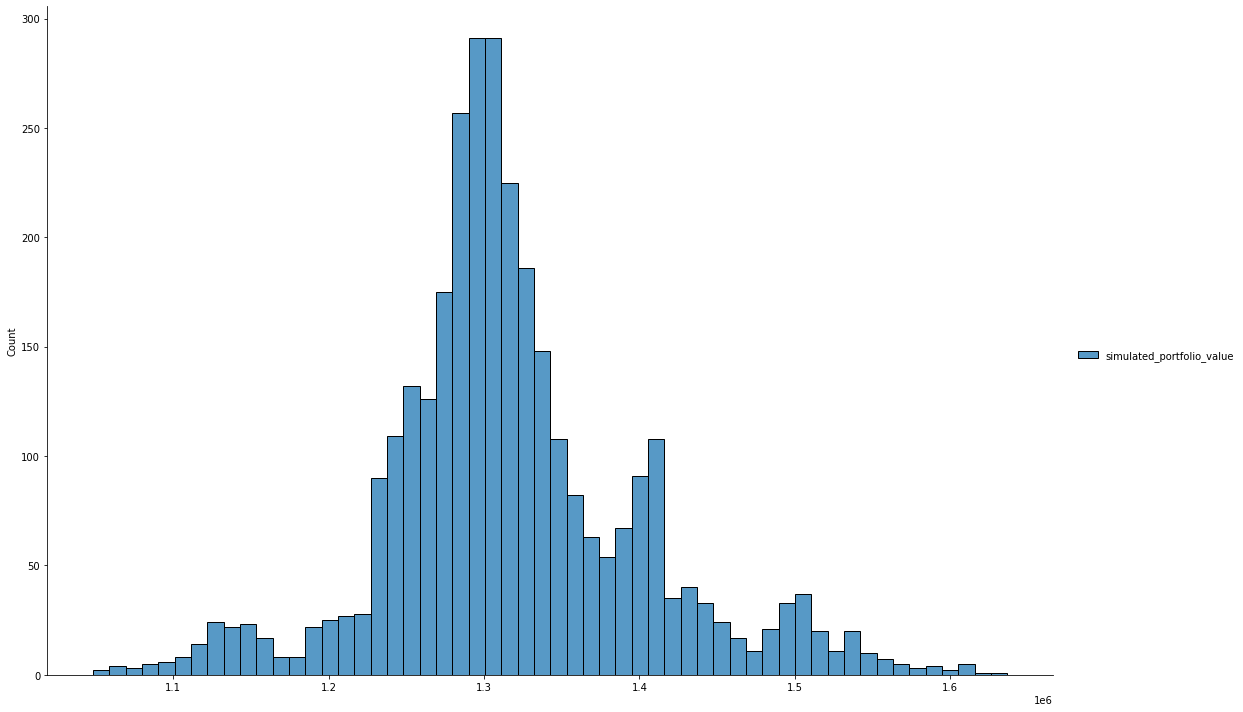

In [37]:
sns.displot(data=simulated_port_end_value_df,  fill=True,  height=10, aspect=1.5)

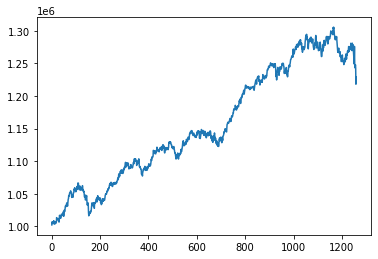

In [38]:
plt.plot(simulation_list[0])

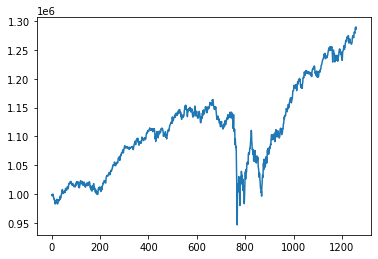

In [39]:
plt.plot(simulation_list[500])

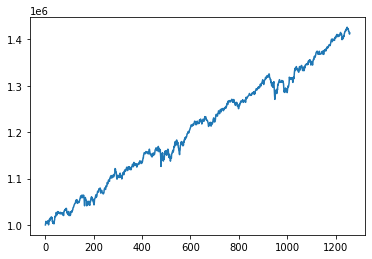

In [40]:
plt.plot(simulation_list[1500])

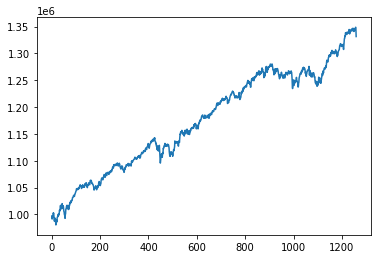

In [42]:
plt.plot(simulation_list[2000])

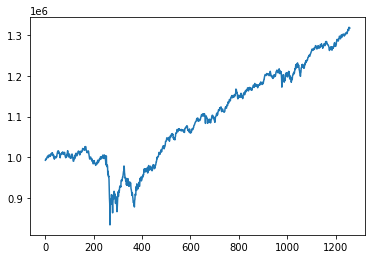

In [49]:
plt.plot(simulation_list[1000])

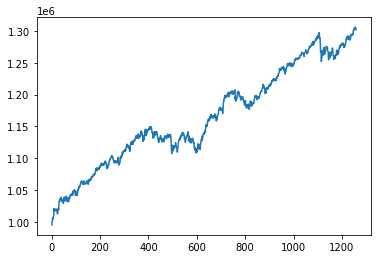

In [43]:
plt.plot(simulation_list[2500])

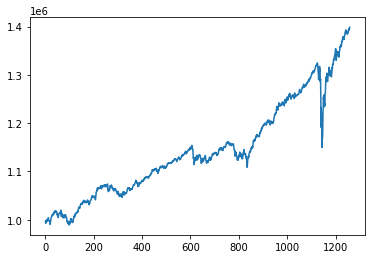

In [44]:
plt.plot(simulation_list[3000])